In [1]:
using JuMP
using Gurobi, Ipopt
using PyPlot
using LinearAlgebra
using CSV
using DataFrames

In [2]:
using NonlinearSolve

In [3]:
curved_left = DataFrame(CSV.File("data\\top.csv"))
curved_right = DataFrame(CSV.File("data\\bottom.csv"))
N = 100
lx = curved_left[!,1][1:N]
ly = curved_left[!,2][1:N]

rx = curved_right[!,1][1:N]
ry = curved_right[!,2][1:N]

100-element Vector{Float64}:
 1.5187513966894628
 1.5888292427526511
 1.6574471336895236
 1.7246050695000794
 1.7903030501843187
 1.8545410757422418
 1.917319146173848
 1.9786372614791379
 2.0384954216581113
 2.0968936267107687
 2.153831876637109
 2.2093101714371337
 2.263328511110842
 ⋮
 2.096893626710768
 2.038495421658111
 1.9786372614791377
 1.9173191461738472
 1.8545410757422407
 1.790303050184318
 1.7246050695000785
 1.6574471336895236
 1.5888292427526505
 1.5187513966894626
 1.4472135954999579
 1.4472135954999579

In [4]:
cx = (lx + rx)/2
cy = (ly + ry)/2
C = [cx cy]

100×2 Matrix{Float64}:
 0.588658  1.28937
 0.62536   1.3538
 0.662876  1.41688
 0.701188  1.47862
 0.740279  1.53901
 0.780132  1.59807
 0.820731  1.65578
 0.862057  1.71215
 0.904094  1.76718
 0.946825  1.82087
 0.990232  1.87321
 1.0343    1.92421
 1.07901   1.97387
 ⋮         
 5.05318   1.82087
 5.09591   1.76718
 5.13794   1.71215
 5.17927   1.65578
 5.21987   1.59807
 5.25972   1.53901
 5.29881   1.47862
 5.33712   1.41688
 5.37464   1.3538
 5.41134   1.28937
 5.44721   1.22361
 5.44721   1.22361

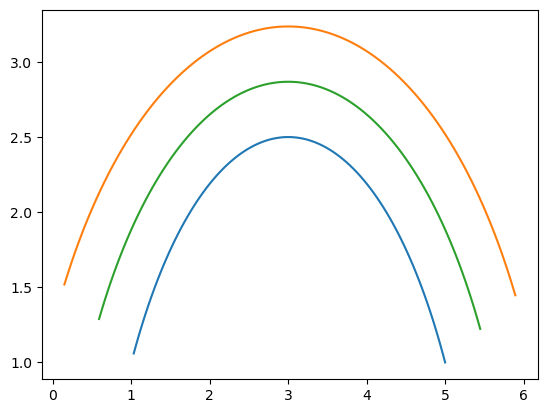

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001ECA4F8DE10>

In [5]:
plot(lx,ly)
plot(rx,ry)
plot(cx,cy)

In [64]:
function E_cur(i)
    i = trunc(Int, i)
    if i == 1
        v1 = X[i,:]
        v2 = X[i+1,:] - X[i,:]
        norm_v1 = v1'*v1
        norm_v2 = v2'*v2
        dTheta = acos( dot(v1,v2)/ (norm_v1*norm_v2))
        deltaX = X[i,:]'*X[i,:]
        return dTheta/deltaX
    elseif i == N
        v1 = X[i,:] - X[i-1,:]
        v2 = -X[i,:]
        norm_v1 = v1'*v1
        norm_v2 = v2'*v2
        v1v2 = dot(v1,v2)
        #dTheta = acos( dot(v1,v2)/ (norm_v1*norm_v2))
        @NLexpression(m, dTheta,  acos(v1v2/ (norm_v1*norm_v2)))
        dx_norm =  (X[i,:] - X[i-1,:])'*(X[i,:] - X[i-1,:]) 
        @NLexpression(m, deltaX, dx_norm)
        return dTheta/deltaX
    else
        v1 = X[i,:] - X[i-1,:]
        v2 = X[i+1,:] - X[i,:]
        norm_v1 = v1'*v1
        norm_v2 = v2'*v2
        
        dTheta = acos( dot(v1,v2)/ (norm_v1*norm_v2))
        deltaX = (X[i,:] - X[i-1,:])'*((X[i,:] - X[i-1,:]))
        return dTheta/deltaX       
    end
end

E_cur (generic function with 1 method)

In [28]:
function E_dev_i(x,y,cx,cy)
    dx = (x - cx)^2
    dy = (y - cy)^2
    return dx + dy
end

E_dev_i (generic function with 3 methods)

In [45]:
m = Model(Ipopt.Optimizer)
#register(m, :E_cur, 1, E_cur, autodiff=true)
register(m, :E_dev_i, 4, E_dev_i, autodiff=true)
w_cur = 1
w_dev = 1
w_obs = 1

@variable(m,x[1:N])
@variable(m, y[1:N])
set_start_value.(X, C)


#delta_theta = [ (x[i] - x[i+1]) for i = 1:99]
#@NLexpression(m, E_cur, w_cur*sqrt(sum(E_cur(i) for i in 1:N)))
@NLexpression(m, E_dev, sum(E_dev_i(x[i],y[i], cx[i], cy[i]) for  i in 1:100))
#@NLexpression(m, E_cur, sum(  acos( dot((X[i,:] - X[i-1,:]), (X[i+1,:] - X[i,:]))/(  ((X[i,:] - X[i-1,:])'*(X[i,:] - X[i-1,:]))*((X[i+1,:] - X[i,:])'*(X[i+1,:] - X[i,:])) )) /  ((X[i,:] - X[i-1,:])'*((X[i,:] - X[i-1,:])))    for i in 2:99) )

@NLobjective(m, Min,  E_dev)
print(m)

optimize!(m)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7143243e+03 0.00e+00 1.09e+01   0.0 0.00e+00    -  0.00e+00 0.00e+00  

In [46]:
xopt = value.(x)
yopt = value.(y)

100-element Vector{Float64}:
 1.2893726374325798
 1.3537963171216578
 1.4168778368172137
 1.478617196519247
 1.5390143962277576
 1.5980694359427465
 1.655782315664212
 1.7121530353921557
 1.7671815951265761
 1.820867994867475
 1.8732122346148508
 1.9242143143687045
 1.973874234129036
 ⋮
 1.8208679948674744
 1.767181595126576
 1.7121530353921552
 1.6557823156642115
 1.5980694359427456
 1.5390143962277572
 1.4786171965192463
 1.4168778368172135
 1.3537963171216572
 1.2893726374325793
 1.223606797749979
 1.223606797749979

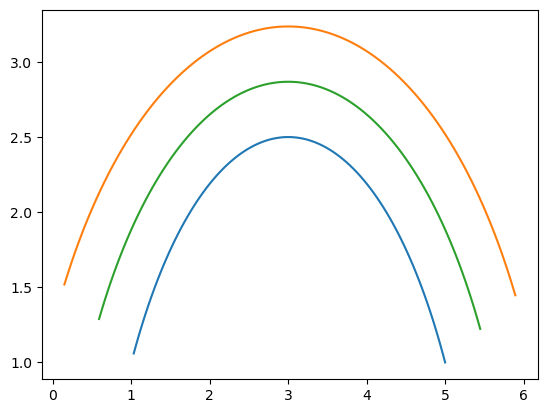

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001ECDB1E91B0>

In [47]:
plot(lx,ly)
plot(rx,ry)
#plot(cx,cy)
plot(xopt,yopt)